In [1]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
import matplotlib.pyplot as plt

In [55]:
# 1. Cargar imágenes y etiquetas
def load_images_from_folders(folder_names, image_size=(300, 300)):
    images = []
    labels = []
    label_map = {name: i for i, name in enumerate(folder_names)}
    
    for folder in folder_names:
        path = os.path.join(".", folder)
        for filename in os.listdir(path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(path, filename)
                img = cv2.imread(img_path)
                if img is None:
                    continue
                img = cv2.resize(img, image_size)
                images.append(img)
                labels.append(label_map[folder])
    
    return np.array(images), np.array(labels), label_map

folders = ["Caras", "Playa", "Cicla"]
images, labels, label_map = load_images_from_folders(folders)

print(f"Total imágenes cargadas: {len(images)}")

Total imágenes cargadas: 59


In [56]:
# 2. Convertir imágenes a vectores (flatten) y normalizar
X_flat = images.reshape(len(images), -1)  # (N, 100*100*3)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)


In [57]:
X_flat.shape

(59, 270000)

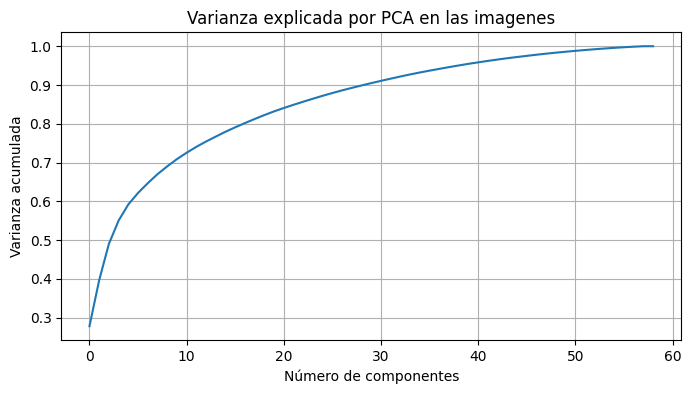

In [58]:
# PCA visualzación
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca_full = PCA()
pca_full.fit(X_scaled)

plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_[:100]))
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada')
plt.title('Varianza explicada por PCA en las imagenes')
plt.grid(True)
plt.show()


In [59]:
# 3. Reducción de dimensiones con PCA
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_scaled)

In [60]:
results = {}
def evaluar(nombre, etiquetas_pred):
    ari = adjusted_rand_score(labels, etiquetas_pred)
    sil = silhouette_score(X_pca, etiquetas_pred)
    results[nombre] = {"ARI": ari, "Silhouette": sil}
    print(f"{nombre}: ARI={ari:.3f}, Silhouette={sil:.3f}")

In [61]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering

In [62]:
# KMeans con diferentes K
for k in [2, 3, 4]:
    km = KMeans(n_clusters=k, random_state=0)
    y_pred = km.fit_predict(X_pca)
    evaluar(f"KMeans k={k}", y_pred)

KMeans k=2: ARI=0.230, Silhouette=0.168
KMeans k=3: ARI=0.137, Silhouette=0.135
KMeans k=4: ARI=0.122, Silhouette=0.108


In [63]:
# Agglomerative con diferentes linkage
for linkage in ['ward', 'complete', 'average']:
    agg = AgglomerativeClustering(n_clusters=3, linkage=linkage)
    y_pred = agg.fit_predict(X_pca)
    evaluar(f"Agglomerative ({linkage})", y_pred)

Agglomerative (ward): ARI=0.080, Silhouette=0.118
Agglomerative (complete): ARI=0.212, Silhouette=0.134
Agglomerative (average): ARI=0.223, Silhouette=0.166


In [64]:
# DBSCAN con diferentes eps
for eps in [100,150,160,170,200,250]:
    db = DBSCAN(eps=eps, min_samples=10)
    y_pred = db.fit_predict(X_pca)
    if len(set(y_pred)) > 1:
        evaluar(f"DBSCAN eps={eps}", y_pred)
    else:
        print(f"DBSCAN eps={eps}: solo un cluster detectado")

DBSCAN eps=100: solo un cluster detectado
DBSCAN eps=150: solo un cluster detectado
DBSCAN eps=160: solo un cluster detectado
DBSCAN eps=170: solo un cluster detectado
DBSCAN eps=200: solo un cluster detectado
DBSCAN eps=250: solo un cluster detectado


In [69]:
# DBSCAN con diferentes eps
for eps in range(400,600,20):
    db = DBSCAN(eps=eps, min_samples=10)
    y_pred = db.fit_predict(X_pca)
    if len(set(y_pred)) > 1:
        evaluar(f"DBSCAN eps={eps}", y_pred)
    else:
        print(f"DBSCAN eps={eps}: solo un cluster detectado")

DBSCAN eps=400: solo un cluster detectado
DBSCAN eps=420: solo un cluster detectado
DBSCAN eps=440: ARI=0.083, Silhouette=0.000
DBSCAN eps=460: ARI=0.102, Silhouette=0.018
DBSCAN eps=480: ARI=0.410, Silhouette=0.054
DBSCAN eps=500: ARI=0.426, Silhouette=0.098
DBSCAN eps=520: ARI=0.352, Silhouette=0.122
DBSCAN eps=540: ARI=0.107, Silhouette=0.057
DBSCAN eps=560: ARI=0.081, Silhouette=0.069
DBSCAN eps=580: ARI=0.037, Silhouette=0.080


In [70]:
# Spectral Clustering
spectral = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', assign_labels='kmeans', random_state=0)
y_pred = spectral.fit_predict(X_pca)
evaluar("Spectral Clustering", y_pred)

Spectral Clustering: ARI=0.237, Silhouette=0.118


In [71]:
# -------------------------------
# 5. Visualización 2D
# -------------------------------
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_scaled)

def plot_clusters(X, y_pred, title):
    plt.figure(figsize=(6,5))
    plt.scatter(X[:,0], X[:,1], c=y_pred, cmap='tab10', s=20)
    plt.title(title)
    plt.axis('off')
    plt.show()

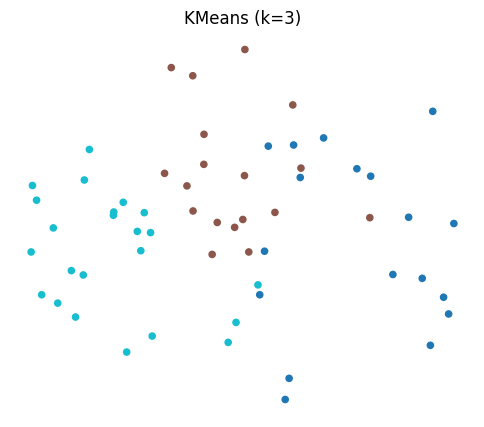

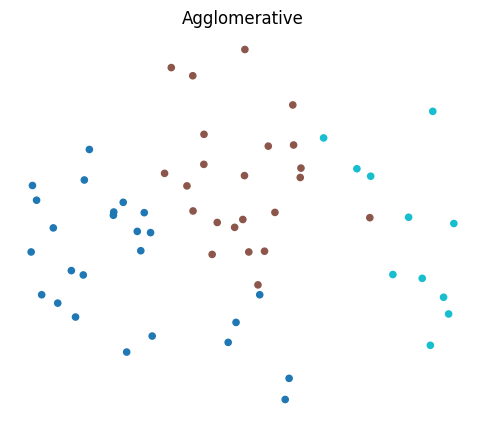

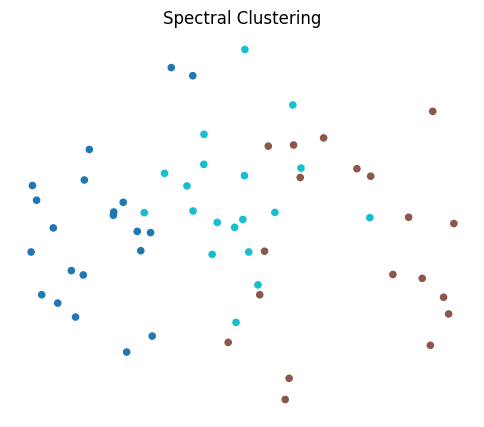

In [72]:
# Mostrar visualización solo de algunos modelos seleccionados
plot_clusters(X_2d, KMeans(n_clusters=3).fit_predict(X_pca), "KMeans (k=3)")
plot_clusters(X_2d, AgglomerativeClustering(n_clusters=3).fit_predict(X_pca), "Agglomerative")
plot_clusters(X_2d, spectral.fit_predict(X_pca), "Spectral Clustering")



📊 Resultados comparativos:
                               ARI  Silhouette
DBSCAN eps=500            0.426226    0.097841
DBSCAN eps=480            0.409876    0.053552
DBSCAN eps=520            0.351773    0.122273
Spectral Clustering       0.237040    0.117761
KMeans k=2                0.230225    0.167565
Agglomerative (average)   0.223325    0.165798
Agglomerative (complete)  0.211854    0.134101
KMeans k=3                0.137461    0.134866
KMeans k=4                0.121557    0.108142
DBSCAN eps=540            0.107065    0.056591
DBSCAN eps=460            0.102367    0.017702
DBSCAN eps=440            0.082869    0.000002
DBSCAN eps=560            0.080647    0.069464
Agglomerative (ward)      0.079579    0.117779
DBSCAN eps=580            0.037274    0.080352
DBSCAN eps=420            0.005496    0.042584


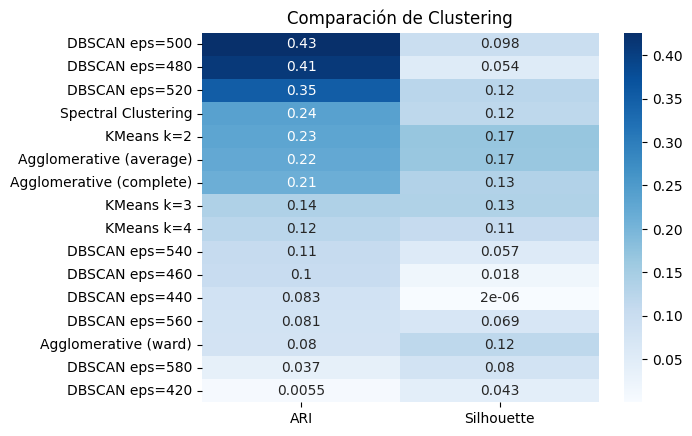

In [75]:
# -------------------------------
# 6. Mostrar tabla comparativa
# -------------------------------
import pandas as pd
import seaborn as sns

df_results = pd.DataFrame(results).T.sort_values("ARI", ascending=False)
print("\n📊 Resultados comparativos:")
print(df_results)

sns.heatmap(df_results, annot=True, cmap="Blues")
plt.title("Comparación de Clustering")
plt.show()